# Connect 4: Exploring Algorithmic Approaches

**Project Context:** Constraint Programming for Connect 4

This notebook outlines and explains various algorithmic approaches that can be considered for developing an intelligent agent to play Connect 4. While the core project might involve Constraint Programming (CP) for aspects like state validation, win condition checking, or perhaps even move generation under certain constraints, this document focuses on common game-playing algorithms that could leverage or complement a CP model.

## 1. Introduction to Connect 4

Connect 4 is a classic two-player connection game in which players first choose a color and then take turns dropping colored discs from the top into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs.

## 2. Constraint Programming (CP) in Connect 4

While the primary decision-making logic for our agents might rely on search algorithms (Minimax, Negamax) or learning (Reinforcement Learning), Constraint Programming offers a powerful declarative paradigm to model and enforce the rules and properties of the Connect 4 game. Instead of explicitly coding *how* to check conditions step-by-step, CP allows us to define the conditions (constraints) that must hold true.

In the context, CP can be strategically employed for several key tasks:

1.  **Board State Representation & Rule Enforcement:**
    *   **Model:** The 6x7 board can be represented using CP variables. For example, a 2D array `board[row][col]` where each variable's domain is `{0, 1, 2}` (representing Empty, Player 1, Player 2).
    *   **Gravity Constraint:** A fundamental rule. We can define constraints stating that if `board[r][c]` is non-empty (belongs to Player 1 or 2), then `board[r-1][c]` must also be non-empty, unless `r` is the bottom row (r=0). This ensures pieces stack correctly.
    *   **Column Capacity:** A constraint can limit the number of non-empty cells in any given column `c` to be at most 6.
    *   **Benefit:** While simple checks are often used in practice for these, using CP provides a formal, declarative model of the game's physics, which can be useful for validation or more complex reasoning.

2.  **Win Condition Checking:**
    *   **Horizontal:** For each player `P` and each possible starting position `(r, c)`, a constraint like: `board[r][c] == P AND board[r][c+1] == P AND board[r][c+2] == P AND board[r][c+3] == P`.
    *   **Vertical:** Similarly: `board[r][c] == P AND board[r+1][c] == P AND board[r+2][c] == P AND board[r+3][c] == P`.
    *   **Diagonal (Both directions):** Analogous constraints for diagonal lines.
    *   **Integration:** This CP-based check is essential for:
        *   **Minimax/Negamax:** Determining if a node is a terminal state (win/loss) in the search tree.
        *   **Reinforcement Learning:** Determining when an episode ends (game over) and assigning the appropriate terminal reward (+1 for win, -1 for loss) in the environment's `step` function.
        *   **All Agents:** Knowing when to stop the game loop.

3.  **Valid Move Identification / Generation:**
    *   Define constraints for a legal move in column `c`: `c >= 0 AND c < 7` AND `board[5][c] == 0` (assuming row 5 is the top row). The actual row a piece lands in depends on the gravity constraint.
    *   **Integration:** Used by the Random agent to pick from legal moves, and by Minimax/Negamax/RL agents to know the available actions from a given state.

5.  **Heuristic Feature Definition (Supporting Minimax/Negamax):**
    *   CP can define what constitutes strategically important patterns, even if calculating them uses procedural code for speed.
    *   **Example:** Define a constraint set representing "a Player 1 three-in-a-row with open space on both ends". The heuristic function could then try to count how many solutions exist for this constraint set on the current board.
    *   **Threat Detection:** Model "a column `c` where Player 2 wins if they play there next". This involves checking if placing Player 2's piece in `c` satisfies a win condition.
    *   **Integration:** CP helps formalize the *features* that the procedural `evaluate_board` function will count or check. Running a CP solver *inside* the heuristic for every node might be too slow, but CP informs the design.

**Summary of CP's Role:** In this project setup, CP is unlikely to be the main AI decision engine itself. Instead, it acts as a powerful **rule engine and state analyzer**. Its primary roles are:
*   **Robustly checking for terminal states (win/loss/draw)**, which is fundamental for all other algorithms.
*   **Formally defining game rules and valid states/moves**, ensuring correctness.
*   Potentially **defining complex features** used by the heuristics in search algorithms like Minimax/Negamax.

## 3. Adversarial Search: Minimax

The **Minimax** algorithm is a cornerstone of game-playing AI, particularly suited for two-player, zero-sum games with perfect information, like **Connect 4**. It provides a systematic way for an AI player to determine the optimal move in any given board state.

### Core Concept: Simulating Connect 4 Futures

Minimax operates by exploring a *game tree* representing possible future states of the Connect 4 board.
*   **Nodes:** Each node in this tree corresponds to a specific configuration of the Connect 4 grid. The root node is the current board state.
*   **Edges:** Each edge represents a legal move – dropping a colored piece into one of the seven columns (provided the column is not full).
The algorithm recursively explores branches of this tree, simulating turns down to a predetermined search depth or until a game-ending state is reached.
*   **Terminal States:** In Connect 4, these are states where one player has achieved four pieces in a row (horizontally, vertically, or diagonally) resulting in a win/loss, or the board is completely full, resulting in a draw. These terminal states are assigned scores: typically +1 for an AI win, -1 for an opponent win, and 0 for a draw.

<center>
    <figure>
        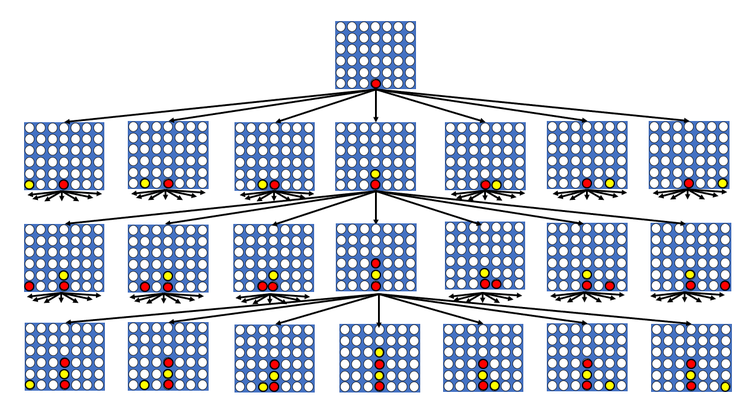
        <figcaption>Example of a minimax Game Tree</figcaption>
    </figure>
</center>

### Maximizing (AI) vs. Minimizing (Opponent) Players

Minimax assumes optimal play from both sides:
*   **Max (Our AI):** Aims to *maximize* the final score. When it's the AI's turn to move (represented by a 'Max' level in the tree), it analyzes the scores resulting from dropping a piece in each valid column and chooses the column leading to the highest possible score.
*   **Min (The Opponent):** Aims to *minimize* the AI's score. When it's the opponent's turn ('Min' level), the algorithm assumes the opponent will choose the column leading to the lowest possible score for the AI.
Scores from deeper levels (or terminal states) are propagated back up the tree. Max nodes take the maximum value of their children, while Min nodes take the minimum.

Minimax uses a *heuristic evaluation function* at its maximum search depth. This function estimates the "goodness" of a non-terminal board state for the AI based on the number of potential winning lines. The AI ultimately chooses the initial column drop that leads to the branch with the highest backed-up score, assuming the opponent always plays perfectly to counter.

### Optimization: Alpha-Beta Pruning for Connect 4 Efficiency

Exploring the full game tree for Connect 4, even a few moves deep, involves analyzing a massive number of board states. **Alpha-Beta Pruning** is an essential optimization that significantly speeds up this process without changing the outcome. It avoids evaluating parts of the game tree that won't influence the final decision. For that, ipl;,.89t maintains two key values during the search:
*   **Alpha (α):** The best (highest) score the AI (Max) can currently guarantee itself on the path from the root to the current node.
*   **Beta (β):** The best (lowest) score the opponent (Min) can currently guarantee forcing on the path from the root to the current node.

Pruning happens in two scenarios relevant to Connect 4 evaluations:
1.  While exploring the opponent's potential moves (Min node): If the evaluation of a potential opponent move yields a score less than or equal to `alpha`, the AI knows the opponent could force a worse outcome for the AI than one already found (`alpha`). Therefore, the AI (Max) would have avoided reaching this state earlier. The algorithm stops exploring further moves down this specific branch (*alpha cutoff*).
2.  While exploring the AI's potential moves (Max node): If the evaluation of a potential AI move yields a score greater than or equal to `beta`, the AI knows this move looks promising, but it also knows the opponent (Min) already has a way to achieve a better (lower) outcome for themselves (`beta`) higher up the tree. Thus, the opponent would never let the game reach this state. The algorithm stops exploring further down this branch (*beta cutoff*).

By eliminating redundant calculations for board states t/hat wouldn't be chosen under optimal play, Alpha-Beta Pruning makes deeper searches in Connect 4 computationally feasible, leading to much stronger AI performance.

## 4. Adversarial Search: Negamax

### Concept
Negamax is a variant of the Minimax algorithm specifically tailored for zero-sum games (where one player's gain is exactly the other player's loss), like Connect 4. It simplifies the Minimax logic by observing that maximizing the score for the current player is equivalent to minimizing the score for the opponent. The core principle is often expressed as `max(score for Player A) = -max(score for Player B)`.

Instead of having separate logic for maximizing and minimizing players, Negamax always attempts to maximize the score from the perspective of the player whose turn it currently is.

### How it Works in Connect 4

1.  **Single Recursive Function:** A single function explores the game tree.
2.  **Score Negation:** When the function recursively calls itself for the opponent's move, the score returned by that call (which represents the best outcome for the *opponent*) is negated (`-eval_score`). This flips the score back to the perspective of the *current* player.
3.  **Maximization:** The function always chooses the move that leads to the maximum score *after* negation.
4.  **Alpha-Beta Pruning:** Pruning works similarly to Minimax, but requires careful handling of the bounds. When making the recursive call, the alpha and beta bounds are swapped and negated (`negamax(..., -beta, -alpha, ...)`). This reflects the change in perspective for the opponent.
5.  **Heuristic & Terminal Evaluation:** Uses the same heuristic evaluation function (`score_position`) as Minimax. Terminal state scores (win/loss/draw) are calculated relative to the *original* AI player making the top-level call.

### Pros
*   **Code Conciseness:** Often results in slightly less code than a traditional Minimax implementation due to the unified recursive logic (no explicit `if maximizing_player:` check).
*   **Theoretical Equivalence:** If implemented correctly with the same heuristic, depth, and pruning logic, it yields the exact same decisions as Minimax.

### Cons
*   **Conceptual Nuance:** The score negation and alpha-beta bound swapping can be slightly less intuitive to understand initially compared to the explicit Max/Min player roles in Minimax.

### Integration with CP
Negamax integrates with CP in the same way as Minimax:
*   Uses CP-verified win checks to identify terminal nodes.
*   Relies on CP-verified valid move generation to know which branches to explore.
*   The heuristic function (`score_position`), while likely procedural for speed, evaluates features (like N-in-a-row, threats) that can be formally defined using CP constraints.

## 5. Monte Carlo Tree Search (MCTS)

### Concept
Monte Carlo Tree Search is a probabilistic search algorithm often used for game AI. Unlike Minimax/Negamax which attempt exhaustive search up to a fixed depth using heuristics, MCTS uses repeated random simulations (playouts) to estimate the value of different moves. It builds a search tree incrementally, focusing more time on promising areas of the game.

### Key Steps (The MCTS Cycle)
MCTS runs for a fixed number of iterations or a time budget. Each iteration involves four phases:

1.  **Selection:** Starting from the root node (current board state), traverse down the existing tree by repeatedly selecting child nodes. The selection typically uses a strategy like UCB1 (Upper Confidence Bound 1 for Trees), which balances **exploitation** (choosing nodes that have historically led to good results) and **exploration** (choosing nodes that haven't been visited much).
2.  **Expansion:** Once a node is reached that is not fully expanded (i.e., has potential moves not yet added as children in the tree) and is not a terminal state, add one (or more) new child nodes to the tree corresponding to an unexplored move.
3.  **Simulation (Playout):** From the newly expanded node (or the selected leaf node if it was terminal), simulate a complete game by making random (or semi-random using a 'default policy') moves for both players until a terminal state (win/loss/draw) is reached.
4.  **Backpropagation:** Take the result of the simulation (+1 for win, -1 for loss, 0 for draw, usually relative to the player whose turn it was at the root) and update the statistics (visit count 'N' and value 'Q') of all nodes along the path taken during the Selection phase, from the simulated node back up to the root.

### How it Works in Connect 4

*   **Tree Structure:** Each node holds a Connect 4 board state, visit count (N), total outcome value (Q), and links to parent/children.
*   **Simulations:** Random or slightly improved playouts determine game outcomes.
*   **Move Choice:** After the allocated iterations/time, the algorithm examines the direct children of the root node. The move corresponding to the child node that is considered 'best' (often the most visited, as it's statistically robust) is chosen as the AI's move.

### Pros
*   **No Heuristic Required (Baseline):** Basic MCTS only needs win/loss/draw results, not a complex board evaluation function (though heuristics can enhance it).
*   **Asymmetric Growth:** Focuses search effort on more promising lines of play.
*   **Anytime Algorithm:** Can be stopped at any time (after any number of iterations) and provide the best move found so far.
*   **Effective in Complex Games:** Works well even with very large state spaces or branching factors where Minimax becomes infeasible.

### Cons
*   **Computationally Intensive:** Requires many simulations (iterations) for strong play.
*   **Simulation Quality:** Performance depends on the quality and speed of the simulation phase. Purely random playouts can sometimes miss obvious tactical threats if not run for enough iterations (mitigated by improved default policies).
*   **Non-Deterministic (Usually):** Due to the randomness in simulations and potentially in tie-breaking during selection, it might not always choose the same move in the same situation.

### Integration with CP
MCTS relies heavily on fast and accurate game rule enforcement, making CP integration valuable:
*   **Simulation Termination:** Needs rapid CP-verified win/loss/draw checks to end simulations.
*   **Valid Moves:** Requires CP-verified valid move generation during both the Expansion phase (creating new nodes) and the Simulation phase (choosing random/policy moves).

## 6. Reinforcement Learning (RL)

### Concept
Reinforcement Learning is a machine learning paradigm where an agent learns to make decisions by taking actions in an environment to maximize a cumulative reward signal. The agent isn't told *what* action to take, but instead discovers which actions yield the most reward through trial and error.

### Key Components
*   **Agent:** The learner or decision-maker (our Connect 4 player).
*   **Environment:** The external system the agent interacts with (the Connect 4 game).
*   **State (s):** A representation of the environment's current situation (the board configuration).
*   **Action (a):** A choice the agent can make (dropping a disc in a column).
*   **Reward (r):** Feedback from the environment indicating the immediate consequence of an action (e.g., +1 for winning, -1 for losing, 0 for other moves).
*   **Policy (π):** The agent's strategy for choosing actions based on states.
*   **Value Function (V(s) or Q(s,a)):** Estimates the expected long-term return (cumulative reward) from a state or state-action pair.

### Relevance to Connect 4
RL allows an agent to learn to play Connect 4 potentially without prior knowledge of optimal strategies, simply by playing many games (often against itself or variations of itself) and learning from the outcomes.

### 6.1 Deep Q-Learning (DQN)

Deep Q-Learning is a popular RL algorithm that uses a deep neural network to approximate the optimal action-value function, known as Q*(s, a). This function represents the maximum expected future reward achievable from state 's' by taking action 'a' and following the optimal policy thereafter.

**How it Works (Briefly):**

1.  **Q-Network:** A neural network takes the current state 's' as input and outputs estimated Q-values for each possible action 'a' in that state.
2.  **Experience Replay:** The agent's experiences (state, action, reward, next_state) tuples are stored in a memory buffer. During training, mini-batches are randomly sampled from this buffer. This breaks temporal correlations and improves learning stability.
3.  **Target Network:** A separate neural network (a periodically updated copy of the main Q-network) is used to calculate the target Q-values for the learning update. This target is `r + γ * max_a'(Q_target(s', a'))`, where `γ` (gamma) is the discount factor for future rewards, `s'` is the next state, and `Q_target` is the value from the target network. Using a fixed target network for a period stabilizes training.
4.  **Learning:** The main Q-network is updated using gradient descent to minimize the difference (e.g., Mean Squared Error) between its predicted Q(s, a) and the calculated target Q-value.
5.  **Exploration:** An exploration strategy (like epsilon-greedy, where the agent takes a random action with probability epsilon, otherwise chooses the action with the highest Q-value) is used to balance exploring new actions and exploiting known good actions.

#### 6.1.1 DQN with a Simple Neural Network (MLP)

*   **Input:** The Connect 4 board (6x7 grid) is typically flattened into a 1D vector (e.g., 42 elements). Each element represents a cell, possibly encoded as 0 (empty), 1 (player 1), -1 (player 2).
*   **Network:** A Multi-Layer Perceptron (MLP) with one or more hidden dense layers (using activation functions like ReLU) followed by an output layer.
*   **Output:** The output layer has 7 neurons, one for each column. The value of each output neuron represents the estimated Q-value for dropping a disc in that column.
*   **Pros:** Relatively simple to implement.
*   **Cons:** Flattening the input loses the spatial relationships between cells (adjacency, lines), which are crucial in Connect 4. The network must learn these relationships implicitly, which can be inefficient.

#### 6.1.2 DQN with a Convolutional Neural Network (CNN)

*   **Input:** The board is treated as a 2D grid (e.g., 6x7). Often, multiple input *channels* are used to represent the state more effectively (e.g., one 6x7 channel indicating positions of player 1's pieces, another for player 2's pieces, maybe a third channel indicating whose turn it is).
*   **Network:** Starts with one or more convolutional layers. These layers use filters (kernels) to detect spatial patterns (like horizontal, vertical, diagonal lines, or local configurations) across the board. Pooling layers might be used to reduce dimensionality. The output from the convolutional/pooling layers is then typically flattened and fed into one or more dense layers (MLP style).
*   **Output:** Similar to the MLP approach, the final output layer has 7 neurons representing the Q-values for each column.
*   **Pros:** CNNs are designed to recognize spatial hierarchies and patterns, making them well-suited for board games like Connect 4. They can learn relevant features more efficiently than MLPs processing flattened input.
*   **Cons:** More complex architecture and more computationally intensive to train than a simple MLP.

In [ ]:
# Code cell for potential DQN structure (pseudo-code or library calls)
# E.g. (Conceptual):
# model = create_cnn_q_network(input_shape=(6, 7, num_channels), output_size=7)
# target_model = create_cnn_q_network(input_shape=(6, 7, num_channels), output_size=7)
# replay_buffer = ReplayBuffer(capacity=10000)
# optimizer = Adam(learning_rate=0.001)
# 
# for episode in range(num_episodes):
#     state = env.reset()
#     done = False
#     while not done:
#         action = select_action_epsilon_greedy(state, model, epsilon)
#         next_state, reward, done, _ = env.step(action)
#         replay_buffer.add(state, action, reward, next_state, done)
#         state = next_state
#         
#         if len(replay_buffer) > batch_size:
#             sample_batch = replay_buffer.sample(batch_size)
#             train_step(model, target_model, sample_batch, optimizer, gamma)
#             
#     # Update target network periodically
#     if episode % target_update_frequency == 0:
#         target_model.set_weights(model.get_weights())
#     
#     # Decay epsilon, log metrics, etc.

## 7. Performance Analysis and Benchmarking (Just as a Draft with fake values for the moment --')

Evaluating the performance of different agents is crucial.

### Metrics
*   **Win Rate:** The primary metric. Percentage of games won against specific opponents.
*   **Draw Rate / Loss Rate:** Complementary to win rate.
*   **Average Game Length:** Can indicate playing style (aggressive vs. defensive).
*   **Computation Time:** Average time taken per move or per game.
*   **(RL Specific) Reward Curve:** Plot of cumulative reward per episode during training.
*   **(RL Specific) Convergence:** How many episodes/steps does it take for the agent's performance to stabilize?

### Benchmarking Setup Example

1.  **Define Agents:** *(TBD)*
    *   `Agent_Minimax_D4`: Minimax agent with search depth 4.
    *   `Agent_Minimax_D6`: Minimax agent with search depth 6.
    *   `Agent_Negamax_D4`: Negamax agent with search depth 4 (should be similar to Minimax D4).
    *   `Agent_RL_FNN`: DQN agent trained with an Feed-Forward NN.
    *   `Agent_RL_CNN`: DQN agent trained with a Convolutional NN.
    *   `Agent_Random`: Plays legal moves randomly.
    *   `Agent_Heuristic`: Plays based on a simple heuristic (e.g., prioritize winning moves, blocking opponent wins, center columns).

2.  **Tournament:** Pit agents against each other in a round-robin or specific matchups. For each matchup (e.g., `Agent_RL_CNN` vs. `Agent_Minimax_D4`), play a significant number of games (e.g., N=200), alternating which agent goes first (N/2 games each).

3.  **Data Collection:** Record wins, losses, and draws for each matchup. For RL agents, track win rate against a fixed benchmark (e.g., `Agent_Random` or `Agent_Minimax_D4`) throughout the training process.

4.  **Presentation:**
    *   **Tables:** Show win/loss/draw percentages for all matchups.

    (**HOW TO PUT A TABLE ON THE LEFT SIDE D:**)
    | Agent          | vs Random | vs Heuristic | vs Minimax D4 | vs RL_CNN |
    |----------------|-----------|--------------|---------------|-----------|
    | Minimax D4     | 95% / 3% / 2% | 70% / 25% / 5% | 50% / 50% / 0%*| 40% / 55% / 5% |
    | RL_CNN         | 98% / 1% / 1% | 85% / 10% / 5% | 55% / 40% / 5% | 50% / 50% / 0%*|

    ```
    (* Self-play results depend on deterministic vs stochastic implementation)
    (Example data only)
    ```


    *   **Graphs:** Plot RL agent win rate vs. training episodes/time. Plot average move time for different agents. (TODO)
6.  **Analysis:** Discuss the relative strengths and weaknesses observed. Does the CNN-based RL agent outperform the MLP-based one? How does RL compare to Minimax at different depths? How significant is the computational cost difference? (TODO)

# 8.Bibliography

### Minimax
* https://en.wikipedia.org/wiki/Minimax
* https://en.wikipedia.org/wiki/Alpha%E2%80%93beta_pruning

### RL
* https://fr.wikipedia.org/wiki/Q-learning
* https://huggingface.co/learn/deep-rl-course/unit3/deep-q-algorithm
* https://www.youtube.com/watch?v=U9nkd2jt3b8
* 